In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import expit
from scipy.interpolate import interp1d

In [3]:
def alpha_beta_spline(V,iBias_alpha_beta,vBias,iSign):
    kappa=0.7
    Ut=26e-3
    I=0
    for spline in xrange(7):
        I += iBias_alpha_beta[spline]*expit((kappa*(vBias[spline] - V)*iSign/Ut))
    return I

Neurodyn Model
$$C_{mem} \frac{dV}{dt} = I_{inj} - I_{Na} - I_{K} - I_L$$
$$I_{Na} = \frac{k}{V_T}I_{1}(V-E_{Na})$$
$$I_{K} = \frac{k}{V_T}I_{2}(V-E_{K})$$
$$I_{L} = \frac{k}{V_T}I_{3}(V-E_{L})$$

where the currents I are functions of the gating variables n, m and h.
As an example we can take $I_{1}$:
$$I_1 = I_{g_{Na}}(\frac{I_m}{I_{ref}})^3\frac{I_h}{I_{ref}}$$
where $I_{g_{Na}} = I_{master}\frac{g_{Na}}{1024}$.  We can think of this equation as matching the usual $I_{Na} = g_{Na}m^3h$. $I_{ref}, g_{Na}$ and $I_{master}$ are all configurable constants with $g_{Na}$ an integer between 0 and 1023.\\
\par Next need to figure out the gating variables $\frac{I_m}{I_{ref}}$, $\frac{I_n}{I_{ref}}$, $\frac{I_h}{I_{ref}}$.  Making $x = \frac{I_x}{I_{ref}}$ we can write the differential equation $$\frac{dx}{dt} = \alpha (1-x) - \beta x$$  $\alpha$ and $\beta$ are summations over sigmoid functions.
$$\alpha = \frac{1}{C_T V_T}\sum_{j=1}^7\frac{I_{master}\alpha_j/1024}{1+\exp{(sign*k(V_{bj}-V)/V_T})}$$
where $\alpha_j$ is a constant between 0-1023.
$V_{bj}$ is defined recursively as follows:
$$V_{bn} = V_{b(n-1)}+I_{factor}*100e3$$ where $V_{b1} = V_{low}+I_{factor}*50e3$ and $I_{factor}$ = $\frac{V_{high}-V_{Low}}{700e-3}$.

In [4]:
#Define constants
V_ref=1.0001 #unit V, 1 volt
I_master=25e-9 # unit A
I_voltage=225e-9# unit A
I_ref=100-9# unit A
KK=0.0636*(0.6836659)*1e-9 # the factor for injecting current.
C_m=4e-12# unit F, 4pF
C_gate=5e-12# unit F, 5pF
kchl=5.5

shift=0 # inject current shift
time_len=200e-3# unit seconds
kappa=0.7
Ut=26e-3 # unit volt, 26mV
Res=1.63e6 #unit ohm, 1.63M ohm

g0=np.array([697.9, 202, 13.9])  # digital value of conductance, they need to be converted to be analog
e_rev=np.array([462.6,-180.3,-231.3]) # digital value of reversal potential

vBias = np.zeros(7)  #define the 7 bias voltages
vHigh=V_ref+Res*I_voltage
vLow=V_ref-Res*I_voltage
I_factor=(vHigh-vLow)/700e3
vBias[0]=0.5840
for index in xrange(1,7):
    vBias[index]=vBias[index-1]+0.1515

    
iSign=np.array([1,-1,-1,1,1,-1])
      
alpha_beta=np.array([[   0,    0,    100,   320,  702,  1023,  1023],
                      [1023, 1023, 1000,  1023,  0,   0,   0],
                      [237,   5,   7,    6,    0,    0,    0],
                      [   0,    0,    0,   0,   41,   25,   8],
                      [   0,    0,    0,    0,   18,   5,   43],
                      [  1,   0,    0,    1,    0,    0,    1]])

iBias_alpha_beta=(I_master/1024)*alpha_beta;

g_f=1/(C_gate*Ut) #gate_factor

# convert digital conductance and reversal potential to analog
g=g0*(kchl)*(I_master/1024); 
E_rev=e_rev*(I_voltage/1024)*Res+V_ref;

g_Na = g[0]
g_K  = g[1]
g_L  = g[2]
E_Na = E_rev[0]
E_K  = E_rev[1]
E_L  = E_rev[2]

time_scale=1

am_v = lambda V: g_f*alpha_beta_spline(V,iBias_alpha_beta[0],vBias,iSign[0])
bm_v = lambda V: g_f*alpha_beta_spline(V,iBias_alpha_beta[1],vBias,iSign[1])
ah_v = lambda V: g_f*alpha_beta_spline(V,iBias_alpha_beta[2],vBias,iSign[2])
bh_v = lambda V: g_f*alpha_beta_spline(V,iBias_alpha_beta[3],vBias,iSign[3])
an_v = lambda V: g_f*alpha_beta_spline(V,iBias_alpha_beta[4],vBias,iSign[4])
bn_v = lambda V: g_f*alpha_beta_spline(V,iBias_alpha_beta[5],vBias,iSign[5])

# Membrane currents (in uA/cm^2)
I_Na = lambda V,m,h: g_Na* m**3 * h*(V - E_Na)
I_K  = lambda V, n: g_K * n**4 * (V - E_K)
I_L  = lambda V: g_L * (V - E_L)


stim=np.loadtxt('IforRealNeuron.csv') #read rcording data
dt = 1e-4
t = np.linspace(0, dt*len(stim), len(stim))
I_extA = interp1d(t, stim*KK+shift)


t = np.arange(0, time_len/2, 1e-4)
#  define the differential equations
def dyn(X, t):
    V, m, h, n = X

    dXdtA = [(I_extA(t) - I_Na(X[0],X[1],X[2]) - I_K(X[0], X[3]) - I_L(X[0]))/C_m,
                       am_v(X[0])*(1-X[1])-bm_v(X[0])*X[1],
                       ah_v(X[0])*(1-X[2])-bh_v(X[0])*X[2],
                       an_v(X[0])*(1-X[3])-bn_v(X[0])*X[3]]
    return dXdtA

In [20]:
X0 = [0.99,0.5,0.5,0.9] #initial guesses
sol = odeint(dyn, X0, t)

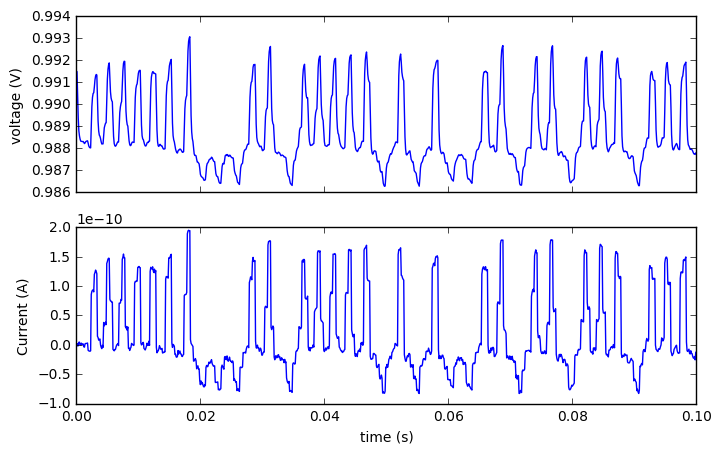

In [24]:
fig, ax = plt.subplots(2, sharex = True, figsize = (8,5))
Vmembrane = sol[:,0]
m = sol[:,1]
h = sol[:,2]
n = sol[:,3]
#plt.plot(t, I_extA(t))
ax[0].plot(t, Vmembrane)
#plt.plot(t, sol[:,1])
#plt.plot(t, sol[:,2])
#plt.plot(t, sol[:,3])
#plt.xlim(0, 0.02)
#ax.set_ylim(0.98, 1)
#X = [0.9,0.5,0.5,0.9]
#plt.plot(v, ah_v(v)*(1-X[2])-bh_v(v)*X[2])
#plt.show()
ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('voltage (V)')
ax[1].set_ylabel('Current (A)')

ax[1].plot(t, I_extA(t))

plt.show()